# 신경망 학습

In [3]:
import numpy as np
from dataset.mnist import load_mnist

## Helper functions

In [4]:
# 손실함수 (Cross Entropy)
def cross_entropy_error(y, t):
    delta = 1e-7 # 0.0000001
    
    if y.ndim == 1:
        t = t.reshape(1, t.size) 
        y = y.reshape(1, y.size)
        
    batch_size = y.shape[0]
    return -np.sum(t*np.log(y+delta))/batch_size

In [5]:
# 신경망에서 사용할 W(Matrix 형태)의 편미분 행렬을 구하는 함수
# 신경망의 기울기 : 그레디언트 (편미분 벡터)
def numerical_gradient(f, x): # x의 shape이 (784, 20) => grads 도 (784, 20)
    h = 1e-4 # 0.0001
    grads = np.zeros_like(x)
    
    it = np.nditer(x, flags=["multi_index"], op_flags=["readwrite"])
        
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]

        x[idx] = tmp_val + h
        fxh1 = f(x) # f(x+h)
        x[idx] = tmp_val - h
        fxh2 = f(x) # f(x-h)
    
        grads[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val
        it.iternext()
        
    return grads

In [6]:
# Softmax
def softmax(x):
    if x.ndim == 2:
        x = x.T # 10*100
        x = x - np.max(x, axis=0) # 10*100 - 100 = 10*100
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

In [7]:
# Sigmoid
def sigmoid(x):
    return 1/(1+np.exp(-x))

## 2층 신경망 구현하기

In [8]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # W1 shape (784, 20), B1 shape (20, ), W2 shape (20, 10). B2 shape (10,)
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        
        a1 = np.dot(x, W1) + b1 # (784,) X (784, 20) + (20,)
        z1 = sigmoid(a1) # (20,)
        
        a2 = np.dot(z1, W2) + b2 # (20,) X (20, 10) + (10,)
        y = softmax(a2) # (10,)
        
        return y
    
    def loss(self, x, t):
        y = self.predict(x)
        loss = cross_entropy_error(y, t)
        return loss      
    
    def accuracy(self, x, t):
        y = self.predict(x) # y는 0~1사이의 확률값
        y = np.argmax(y, axis=1) # y는 클래스의 인덱스
        t = np.argmax(t, axis=1)
        accuracy = np.sum(y==t)/x.shape[0]
        
        return accuracy
    
    def numerical_gradient(self, x, t):
        f = lambda w : self.loss(x, t)
        
        # W1 shape (784, 20), B1 shape (20, ), W2 shape (20, 10). B2 shape (10,)
        grads = {}
        grads["W1"] = numerical_gradient(f, self.params['W1']) # W1 (784, 20) --> dW1 (784, 20)
        grads["b1"] = numerical_gradient(f, self.params['b1']) # b1 (20,) --> db1 (20,)
        grads["W2"] = numerical_gradient(f, self.params['W2']) # W2 (20, 10) --> dW2 (20, 10)
        grads["b2"] = numerical_gradient(f, self.params['b2']) # b2 (10,) --> db2 (10,)
        
        return grads
    
    def gradient(self, x, t):    
        grads = {}
        
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        batch_size = x.shape[0]
        da2 = (y-t)/batch_size
        
        db2 = np.sum(da2, axis=0) ##
        dw2 = np.dot(z1.T, da2) ##
        
        dz1 = np.dot(da2, W2.T)
        da1 = (1-z1)*z1*dz1
        
        db1 = np.sum(da1, axis=0) ##
        dw1 = np.dot(x.T, da1) ##
        
        grads['W1'], grads['W2'] = dw1, dw2
        grads['b1'], grads['b2'] = db1, db2
        
        return grads

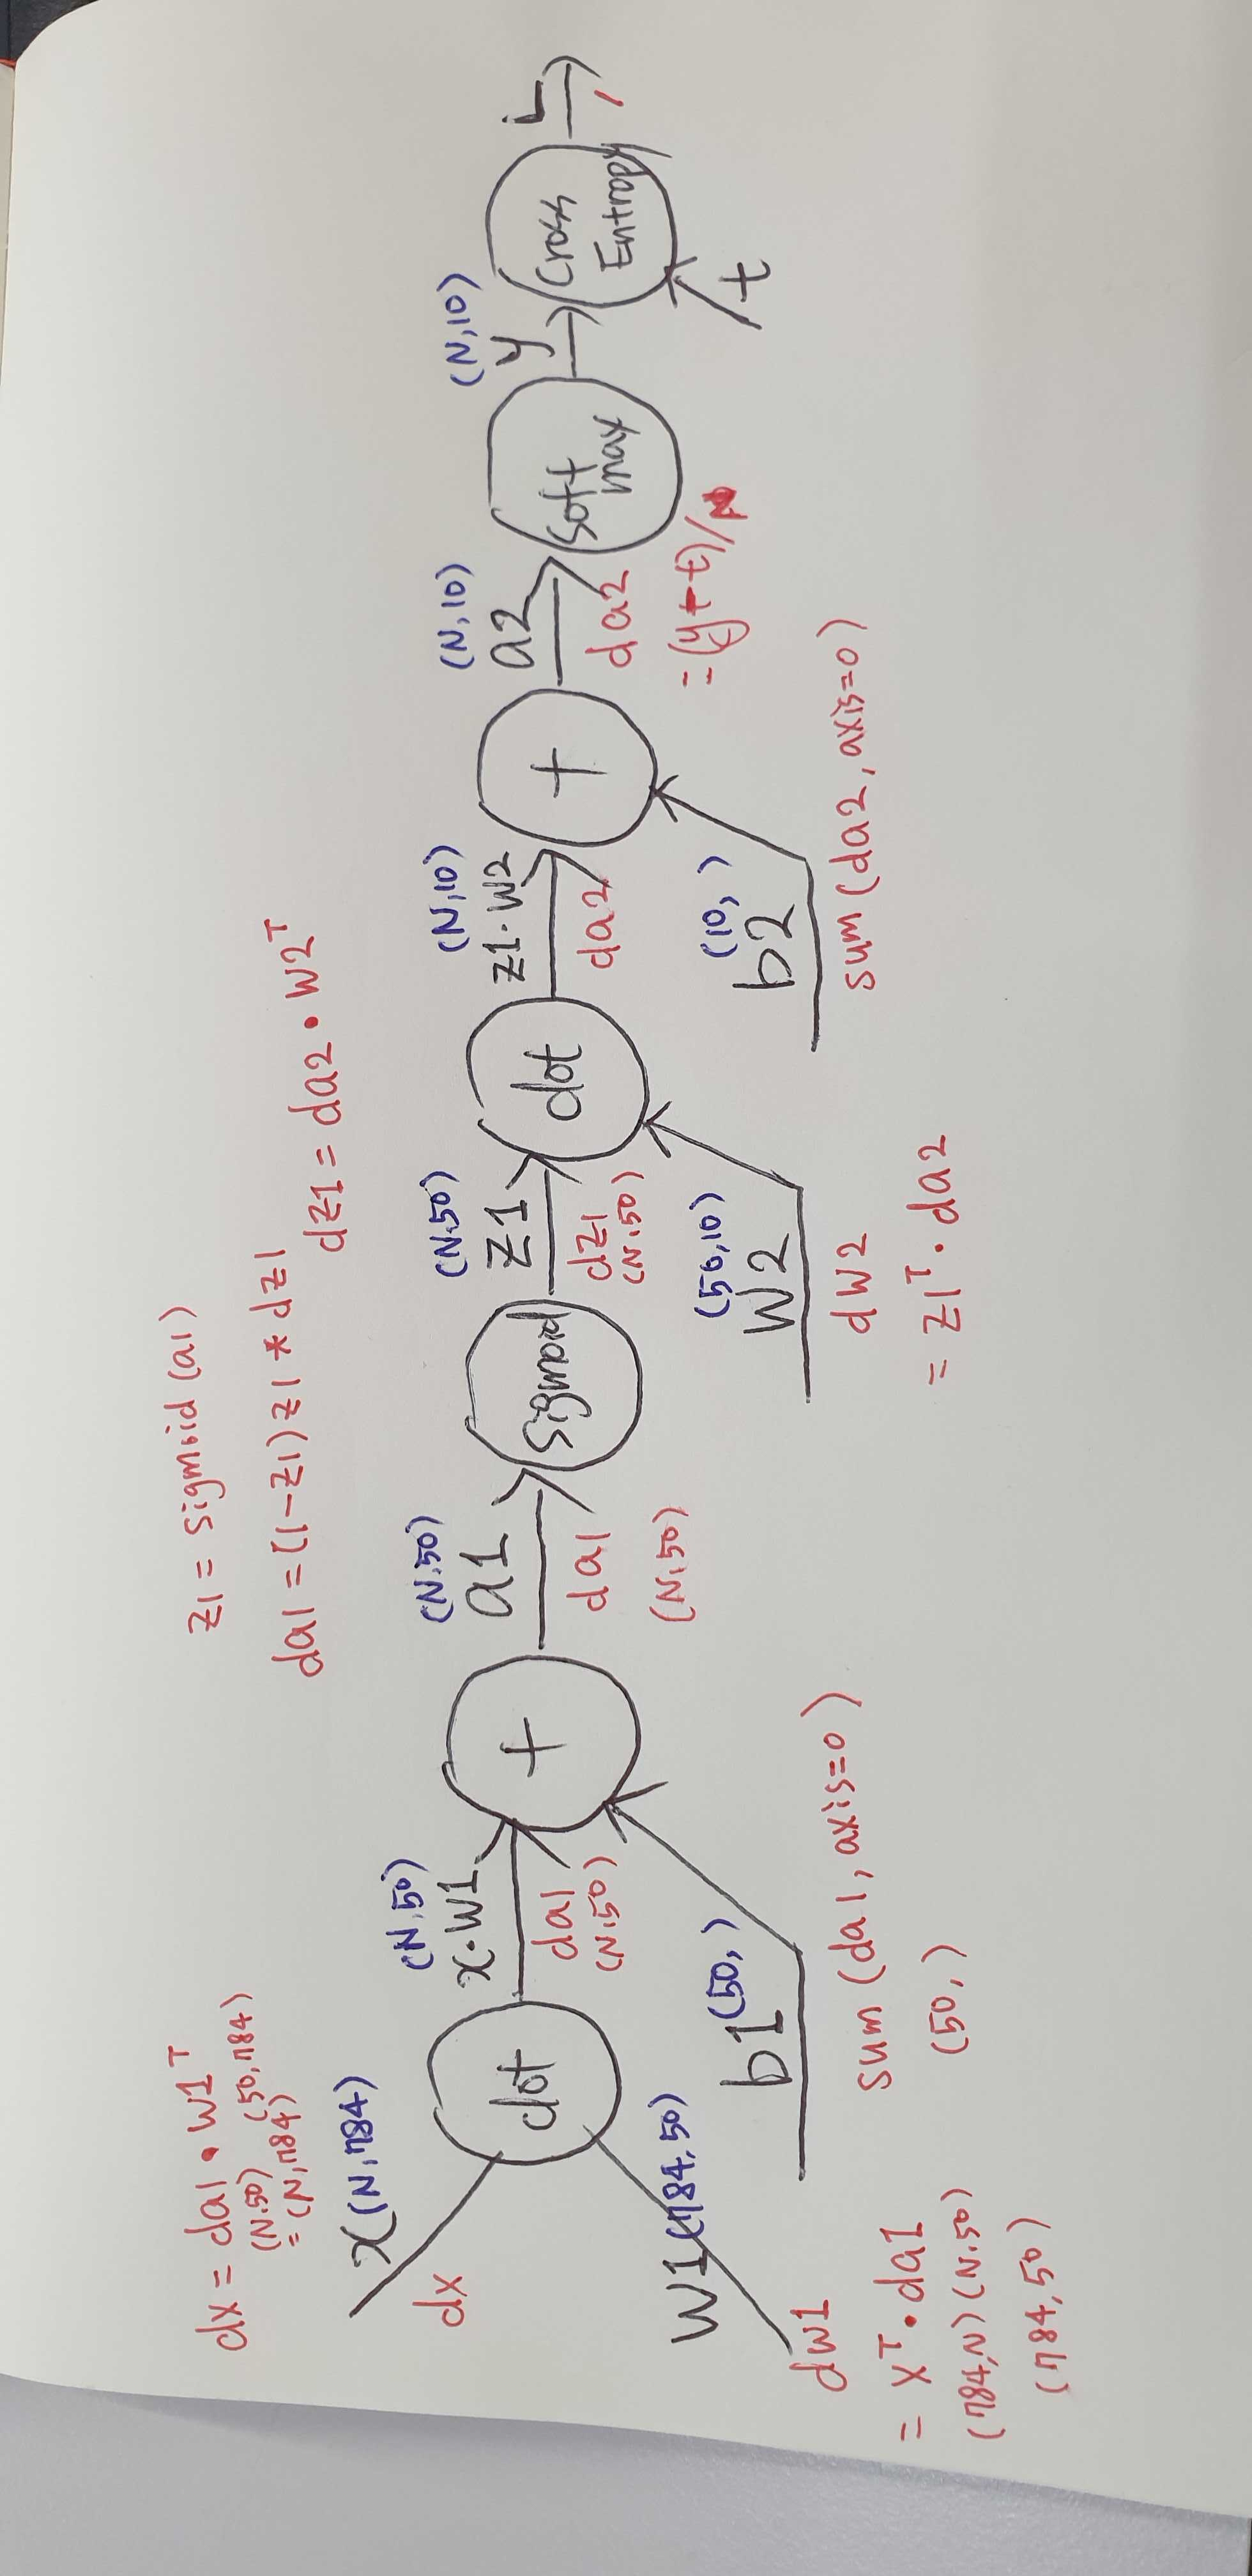

In [9]:
from IPython.display import Image
Image('오차 역전파.jpg', width=600)

In [11]:
X_train.shape

(60000, 784)

In [15]:
(X_train, y_train), (X_test, y_test) = load_mnist(normalize=True, flatten=True, one_hot_label=True)

network = TwoLayerNet(input_size = 784, hidden_size=20, output_size=10)

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 하이퍼파라미터
iters_num = 10000
batch_size = 100 # 미니배치 사이즈
learning_rate = 0.1

# 1 에폭(epoch) : 훈련데이터 전체를 소진하는데 걸리는 시간
# 60,000개의 훈련 데이터를 100개(배치사이즈)씩 학습 했을 때 모두 소진하는데 걸리는 횟수 : 600번
train_size = X_train.shape[0] # 60,000
iter_per_epoch = train_size/batch_size # 60000(전체)/100(배치) = 600번

for i in range(iters_num): # 0, 1, 2, 3, .....10000
    batch_mask = np.random.choice(60000, 100) # 랜덤하게 뽑은 배치의 인덱스
    x_batch = X_train[batch_mask]
    t_batch = y_train[batch_mask]

    # 1. Gradient 
    grads = network.gradient(x_batch, t_batch)

    # 2. Gradent Descent (모델 파라미터 업데이트)
    for keys in ('W1', 'W2', 'b1', 'b2'):
        # W(new) <- W(old) - (lr * Gradient) : 경사 하강법
        network.params[keys] = network.params[keys] - (learning_rate * grads[keys])

    loss = network.loss(x_batch, t_batch)  
    train_loss_list.append(loss)
    
    # epoch 마다 로그 출력하기 - 600, 1200, 1800, 2400,......
    if i % iter_per_epoch == 0: # 600, 1200, ....
        train_accuracy = network.accuracy(X_train, y_train)
        test_accuracy = network.accuracy(X_test, y_test)
        train_acc_list.append(train_accuracy)
        test_acc_list.append(test_accuracy)
        print(str(i) + ' : Train Accuracy : ' + str(train_accuracy) + '  Test Accuracy' + str(test_accuracy))

0 : Train Accuracy : 0.10716666666666666  Test Accuracy0.1073
600 : Train Accuracy : 0.7128166666666667  Test Accuracy0.725
1200 : Train Accuracy : 0.8589  Test Accuracy0.8621
1800 : Train Accuracy : 0.8887  Test Accuracy0.8899
2400 : Train Accuracy : 0.90265  Test Accuracy0.9052
3000 : Train Accuracy : 0.9094333333333333  Test Accuracy0.9127
3600 : Train Accuracy : 0.9154666666666667  Test Accuracy0.9174
4200 : Train Accuracy : 0.92075  Test Accuracy0.9212
4800 : Train Accuracy : 0.9239833333333334  Test Accuracy0.9236
5400 : Train Accuracy : 0.9275666666666667  Test Accuracy0.9271
6000 : Train Accuracy : 0.93005  Test Accuracy0.9295
6600 : Train Accuracy : 0.9316333333333333  Test Accuracy0.9309
7200 : Train Accuracy : 0.9346833333333333  Test Accuracy0.9341
7800 : Train Accuracy : 0.9360333333333334  Test Accuracy0.9353
8400 : Train Accuracy : 0.9377333333333333  Test Accuracy0.9376
9000 : Train Accuracy : 0.9394  Test Accuracy0.9377
9600 : Train Accuracy : 0.9411166666666667  Test 

In [16]:
import matplotlib.pyplot as plt

**정확도(Accuracy)**

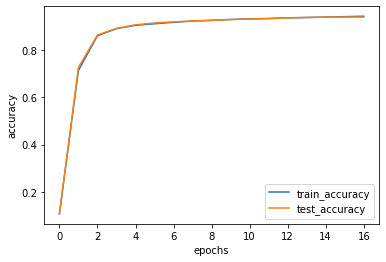

In [22]:
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train_accuracy')
plt.plot(x, test_acc_list, label='test_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

**손실값(Loss)**

Text(0, 0.5, 'Loss')

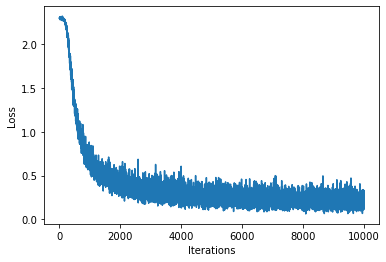

In [25]:
x = np.arange(len(train_loss_list))
plt.plot(x, train_loss_list)
plt.xlabel('Iterations')
plt.ylabel('Loss')

Text(0, 0.5, 'Loss')

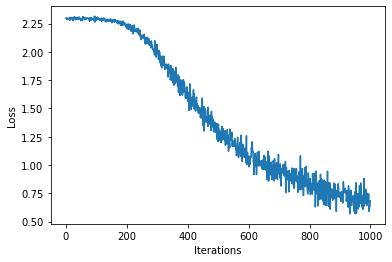

In [26]:
x = np.arange(len(train_loss_list)-9000)
plt.plot(x, train_loss_list[:1000])
plt.xlabel('Iterations')
plt.ylabel('Loss')